# Language Modelling Script

In [2]:
import pandas as pd
import numpy as np
import pickle, logging, spacy, sys, os, json, requests
import matplotlib.pyplot as plt

from helpers.classes import Collection
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime

In [3]:
from helpers.cloze_generation import generate_clozes_from_point, named_entity_answer_generator as ne_answer_generator, noun_phrase_answer_generator as np_answer_generator

from helpers.language_modelling import run_language_model, summarise_results

df = pd.read_pickle('pickles/dataset_20210625_184837.pkl')
clozes_df = pd.read_json('pickles/clozes_20210715_212425.json')

# Data (Bulletin Main-Points) Preview

In [3]:
for points in df.point[:5]:
    print(points + '\n')

In 2019, approximate gross value added at basic prices (aGVA) of the UK non-financial business economy was estimated to be £1,313.9 billion; an increase of £42.8 billion (3.4%) compared with 2018.

The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to £744.4 billion; transport and storage saw the highest increase in aGVA growth at £7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.

Total turnover and purchases of the UK non-financial business economy were estimated to be £4,101.5 billion and £2,761.4 billion respectively; an increase of £70.5 billion (1.7%) and £25.8 billion (0.9%) compared with 2018.

Out of the 12 UK regions, 8 regions experienced growth in aGVA; the South East experienced the largest increase in aGVA of £17.3 billion to £214.4 billion, which was as increase of 8.8% in 2019.

West Midlands, Yorkshire and The Humber, Scotland and East Midlands, were the four regions decreasin

The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to £744.4 billion; transport and storage saw the highest increase in aGVA growth at £7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.


The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to £74.4 billion; transport and storage saw the highest increase in aGVA growth at £7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.

The non-financial services sector, which accounted for over half (56.7%) of total aGVA in 2019, increased by £25 billion (3.5%) to `<mask><mask><mask>`; transport and storage saw the highest increase in aGVA growth at 
£7.2 billion (8.6%) increasing from £84.4 billion to £91.6 billion.



a) Barack Obama and Trump both ran for president, and `mask` won.
b) Barack Obama and Trump both ran for president, and `mask``mask` won.
c) Barack Obama and Trump both ran for president, and `mask``mask``mask` won.

mean(a, b, c)

by averaging the probs of products of tokens we reduce the preference to shorter answers
(https://arxiv.org/pdf/2104.08315.pdf)


# Single Token Answers

In [4]:
RUN = False

## BERT Single Token Answers

In [5]:
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from helpers.configs import CLOZE_MASKS
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/bert_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/bert_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/bert_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
print('BERT Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

BERT Single-Token Answers:

Total Examples: 6184
Correct: 179, Incorrect: 6005
Percentage Correct: 2.895%


## ELECTRA Single Token Answers

In [7]:
from transformers import ElectraForMaskedLM, ElectraTokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraForMaskedLM.from_pretrained('google/electra-small-discriminator')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/electra_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/electra_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/electra_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForMaskedLM: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['generator_predictions.LayerNorm.weight', 'generator_predictions.La

In [8]:
print('ELECTRA Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

ELECTRA Single-Token Answers:

Total Examples: 6184
Correct: 0, Incorrect: 6184
Percentage Correct: 0.0%


## AlBERT Single Token Answers

In [9]:
from transformers import AlbertForMaskedLM, AlbertTokenizer
model = AlbertForMaskedLM.from_pretrained('albert-base-v2')
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/albert_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/albert_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/albert_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

In [10]:
print('AlBERT Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

AlBERT Single-Token Answers:

Total Examples: 6184
Correct: 216, Incorrect: 5968
Percentage Correct: 3.493%


## RoBERTa Single Token Answers

In [11]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
model = RobertaForMaskedLM.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

if RUN:
    results, entity_set, entities = run_language_model(df, model, tokenizer, 
        save_results= True, multi_token= False)
else:
    # load back if you didn't run them
    with open('results/roberta_base_check_model_july2.json', 'r') as f:
        results = json.load(f)
    with open('results/roberta_base_entity_set_july2.pickle', 'rb') as f:
        entity_set = pickle.load(f)
    with open('results/roberta_base_entity_dictionary.json', 'r') as f:
        entities = json.load(f)

In [12]:
print('RoBERTa Single-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

RoBERTa Single-Token Answers:

Total Examples: 6184
Correct: 715, Incorrect: 5469
Percentage Correct: 11.562%


# Multi-Token Answers

In [13]:
# RAN ON GOOGLE COLAB
# via run_multitoken_languagemodel.py

In [14]:
from transformers import RobertaForMaskedLM, RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

with open('results/RobertaForMaskedLM_20210714_192239_results.json', 'r') as f:
    results = json.load(f)
with open('results/RobertaForMaskedLM_20210714_192239_entity_set.pickle', 'rb') as f:
    entity_set = pickle.load(f)
with open('results/RobertaForMaskedLM_20210714_192239_entity_dictionary.json', 'r') as f:
    entities = json.load(f)

In [15]:
print('RoBERTa Multi-Token Answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

RoBERTa Multi-Token Answers:

Total Examples: 6184
Correct: 654, Incorrect: 5530
Percentage Correct: 10.576%


# Why is Multi-Token RoBERTa worse than the Single-Token counterpart?

In [54]:
with open('results/roberta_base_check_model_july2.json', 'r') as f:
        single_results = json.load(f)
with open('results/RobertaForMaskedLM_20210714_192239_results.json', 'r') as f:
        multi_results = json.load(f)

In [84]:
agree, disagree = 0, 0
disagreements = []

single_correct, multi_correct = [], []

agree_correct, agree_incorrect = [], []

disagree_single_correct, disagree_multi_correct = [], []

for row in range(2015):
    single_row, multi_row = single_results[row], multi_results[row]
    if len(single_row) and len(multi_row):
        for single, multi in zip(single_row, multi_row):
            
            single_pred = single[0]
            multi_pred = multi[0]
            truth = single[2]
            
            # make sure first char isn't a whitespace
            if single_pred[0] == ' ':
                single_pred = single_pred[1:]
            if multi_pred[0] == ' ':
                multi_pred = multi_pred[1:]

            # if single-token and multi-token identical
            if single_pred == multi_pred:
                agree += 1
                # if they match truth
                if single_pred == truth:
                    # print(single_pred, multi_pred)
                    # print(multi)
                    agree_correct.append((truth))
                # if they both are wrong
                else:
                    agree_incorrect.append((single_pred, multi_pred, truth))
            
            # if single-token and multi-token disagree
            else:
                disagree += 1
                disagreements.append((single_pred, multi_pred, truth))
                # if single-token is correct
                if single_pred == truth:
                    disagree_single_correct.append((single_pred, multi_pred, truth))
                # if multi-token is incorrect
                if multi_pred == truth:
                    disagree_multi_correct.append((single_pred, multi_pred, truth))

In [73]:
print(f'Out of {agree} times that single- and multi-token predictions agreed: \n Both were {len(agree_correct)} correct and {len(agree_incorrect)} incorrect\n')

print(f'Out of {disagree} times that single- and multi-token predictions disagreed: \n Single-token was {len(disagree_single_correct)} correct and Multi-token was {len(disagree_multi_correct)} correct')

Out of 1385 times that single- and multi-token predictions agreed: 
 Both were 541 correct and 844 incorrect

Out of 4799 times that single- and multi-token predictions disagreed: 
 Single-token was 174 correct and Multi-token was 113 correct


In [75]:
disagree_multi_correct[:5]

[('It', 'Scotland', 'Scotland'),
 ('California', 'London', 'London'),
 ('2015', 'last year', 'last year'),
 ('New', 'Monthly', 'Monthly'),
 ('Scotland', 'London', 'London')]

How do we explain that:

"Wales" is tokenised as two tokens. Single-token prediction (i.e. we just pass a single `<mask>`) is better? 

# Looking into the predictions

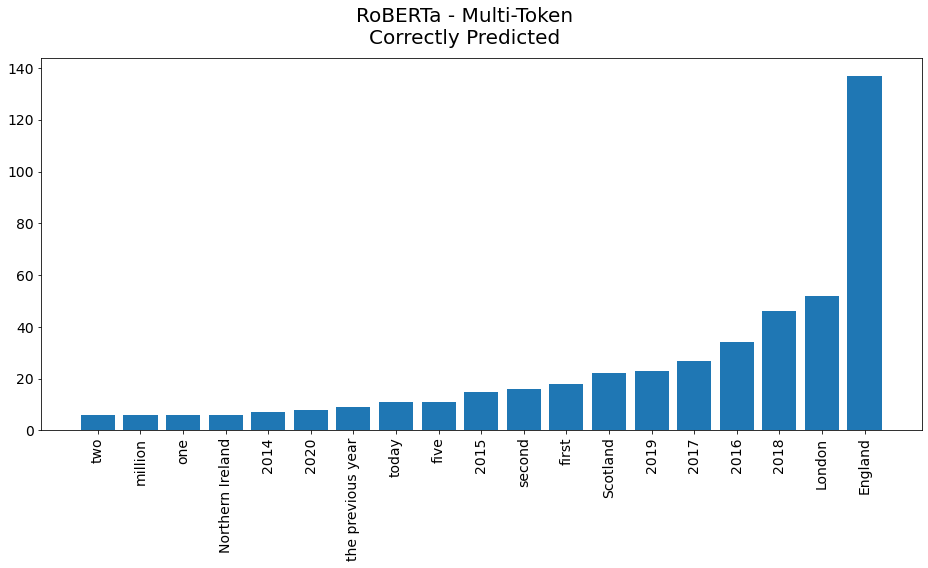

In [19]:
preds, counts = np.unique(correct_preds, return_counts = True)


_sorted = pd.DataFrame({'preds': preds, 'counts':counts}).sort_values('counts')

fig, ax = plt.subplots(1, 1, figsize= (13,8))
plt.bar(_sorted.preds[_sorted.counts > 5], _sorted.counts[_sorted.counts > 5])
# plt.bar(preds[counts > 5], counts[counts > 5])
ax.tick_params(axis='x', labelsize=14, rotation = 90)
ax.tick_params(axis='y', labelsize=14)
fig.suptitle('RoBERTa - Multi-Token\nCorrectly Predicted', fontsize = 20)
plt.tight_layout()
plt.show()

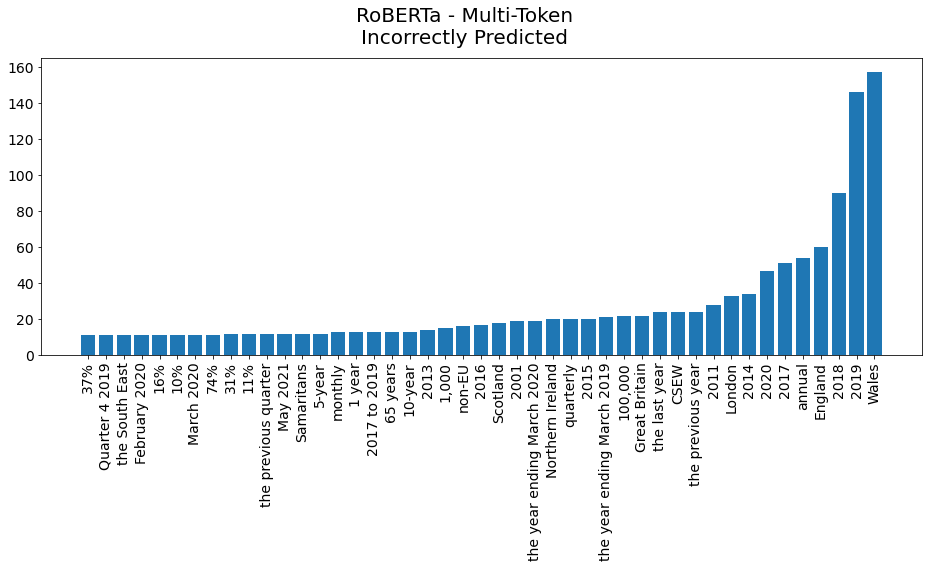

In [17]:
preds, counts = np.unique([x[1] for x in wrong_preds], return_counts = True)


_sorted = pd.DataFrame({'preds': preds, 'counts':counts}).sort_values('counts')

fig, ax = plt.subplots(1, 1, figsize= (13,8))
plt.bar(_sorted.preds[_sorted.counts > 10], _sorted.counts[_sorted.counts > 10])
ax.tick_params(axis='x', labelsize=14, rotation = 90)
ax.tick_params(axis='y', labelsize=14)
fig.suptitle('RoBERTa - Multi-Token\nIncorrectly Predicted', fontsize = 20)
plt.tight_layout()
plt.show()

- Ask Patrick (researchquestions) if he knows any ways to handle probabilities of different length tokens (preference of shorter tokens)

- Ask Patrick/Seb/ (RQ) is there a way to use t5 to answer cloze-style questions? papers links

- LREC maybe, submission of dataset, compare with PolitiHop, benchmark argument

In [4]:
with open('results/RobertaForMaskedLM_20210719_234849_results.json', 'r') as f:
    results = json.load(f)

In [5]:
print('RoBERTa best of 0-5 token-length answers:\n')
count_correct, count_wrong, correct_preds, wrong_preds = summarise_results(results)

RoBERTa best of 0-5 token-length answers:

Total Examples: 6184
Correct: 646, Incorrect: 5538
Percentage Correct: 10.446%


In [1]:
results

NameError: name 'results' is not defined

In [6]:
results

[[['2019',
   0.5354322791099548,
   '2019',
   0,
   'ccf75a2c157eacc5253f0e8a55b1ded9f5386d58'],
  ['pounds billion pounds',
   1.6175238641521466,
   '£1,313.9 billion',
   0,
   'fc3346f2545ca5059bdb5150b998300c5001bea5'],
  ['% growth',
   0.8860111998208877,
   '£42.8 billion',
   0,
   '81aa32270d547a368e7b806646c72069ba4fac43'],
  ['aVAA',
   1.648535256871221,
   '3.4%',
   0,
   'f308eb661ad1d6c8021cf9e22d8e8c7d9c5ff50e'],
  ['2018',
   0.8733159303665161,
   '2018',
   0,
   '0a0bcf4b990f1926bc87fa662badadaf7e23d5fa']],
 [],
 [['£ billion billion',
   2.214230118642562,
   '£4,101.5 billion',
   2,
   '0ff2c435e1d192045540e12b44315fa61592a451'],
  ['£,,, billion',
   4.769513084322743,
   '£2,761.4 billion',
   2,
   '1226559ad975ee3d495c004eb469d294d87bfd5d'],
  ['£ billion billion',
   2.753080542539142,
   '£70.5 billion',
   2,
   '8444327426fe4840ba8daa1f5058bba3bee0eb42'],
  ['...%',
   3.2442595547673196,
   '1.7%',
   2,
   'ee292c95bfec63841e1eb11786ced73e918660d2']

In [ ]:
United States of America

<mask> <mask> <mask> <mask>

<mask> States of <mask>

@yao -- how to use MLM for answering cloze style question, if the answer is composed of multi token answers

@ fabio petroni -- language models as knowledge bases (LAMA); 

2019 -- 0.6

'2018 of' -- (0.58, 0.9) -- [0.58 + (0.58 * 0.9)] / 2
